### Homework 2: RNN
Problem 1: Text Generation (fake reviews)
Text generation serves various purposes like machine translation, chatbots, virtual assistants, and AIGC. To understand the text generation process with a language model, consider it as an iterative approach. Initially, we predict the first word from the input sequence and subsequently use that predicted word in the input to generate the second word. Repeat the process until done.  

If we recall, we focused on letter generation in class. Now, using the review data in HW1, let's build upon the in-class examples to create a simulated review using a GRU or LSTM model. For simplicity's sake, let's concentrate on coding the training process without delving into hyperparameter tuning or model evaluations. We'll generate both a negative review (combining 1-star, 2-star, and 3-star comments) and a positive review (utilizing 4-star and 5-star comments). Essentially, our goal is to generate tokens instead of individual letters.

In [1]:
# import google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install d2l==0.17.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.

# 1. Language Model

In [4]:
import os
import d2l
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import collections
import re
from d2l import torch as d2l
from torchtext import data

In [5]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
lines

['the time machine by h g wells',
 '',
 '',
 '',
 '',
 'i',
 '',
 '',
 'the time traveller for so it will be convenient to speak of him',
 'was expounding a recondite matter to us his grey eyes shone and',
 'twinkled and his usually pale face was flushed and animated the',
 'fire burned brightly and the soft radiance of the incandescent',
 'lights in the lilies of silver caught the bubbles that flashed and',
 'passed in our glasses our chairs being his patents embraced and',
 'caressed us rather than submitted to be sat upon and there was that',
 'luxurious after dinner atmosphere when thought roams gracefully',
 'free of the trammels of precision and he put it to us in this',
 'way marking the points with a lean forefinger as we sat and lazily',
 'admired his earnestness over this new paradox as we thought it',
 'and his fecundity',
 '',
 'you must follow me carefully i shall have to controvert one or two',
 'ideas that are almost universally accepted the geometry for',
 'instance the

In [8]:
# Import the random module for generating random numbers
import random
# Import the torch module for deep learning tasks
import torch
# Import the torch module alias from the d2l library
from d2l import torch as d2l

# Use the function from the d2l library to read the time machine text and tokenize it
tokens = d2l.tokenize(lines)
# Concatenate all the words in tokens into a list to generate the corpus
corpus = [token for line in tokens for token in line]
# Build a vocabulary vocab using the corpus
vocab = d2l.Vocab(corpus)
# Output the top 10 words with their corresponding frequencies in the vocabulary
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

In [9]:
# Convert vocab to a dataframe

df_freq = pd.DataFrame(vocab.token_freqs, columns=['word', 'freq'])
df_freq

,word,freq
0,the,2261
1,i,1267
2,and,1245
3,of,1155
4,a,816
...,...,...
4574,cheerlessly,1
4575,advancement,1
4576,makers,1
4577,casual,1


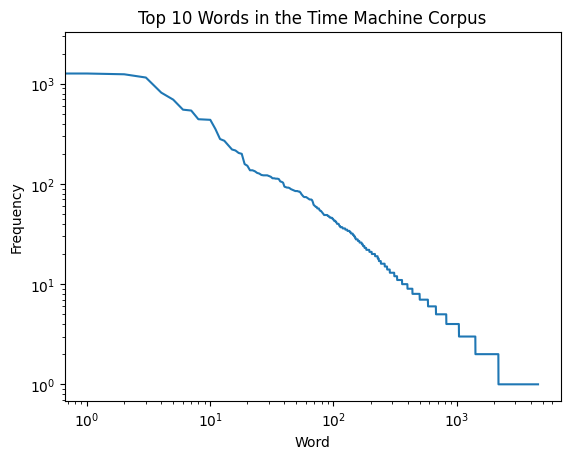

In [13]:
# Plot df_freq["freq"].index and df_freq["freq"] on a Log scale

plt.plot(df_freq["freq"].index, df_freq["freq"])
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Top 10 Words in the Time Machine Corpus")
plt.show()

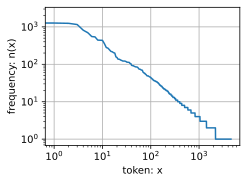

In [28]:
# Plot a word frequency chart where the most popular words are referred to as stop words
# Extract frequency information from the vocabulary's token_freqs and store it in the freqs list
freqs = [freq for token, freq in vocab.token_freqs]
# Use the plot function from the d2l library to draw the word frequency chart
# Set the horizontal axis as token, the vertical axis as the corresponding frequency,
# and use a logarithmic scale for both the horizontal and vertical axes
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log', yscale='log')

In [29]:
# How about other word combinations, such as bigrams and trigrams?
# Use a list comprehension to form pairs of adjacent words in the corpus and store them in the bigram_tokens list
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]  # Bigrams

# Build the vocabulary for bigrams using bigram_tokens
bigram_vocab = d2l.Vocab(list(map(str, bigram_tokens)))

# Output the top 10 most frequent bigram tokens and their corresponding frequencies in the bigram vocabulary
bigram_vocab.token_freqs[:10]

[("('of', 'the')", 309),
 ("('in', 'the')", 169),
 ("('i', 'had')", 130),
 ("('i', 'was')", 112),
 ("('and', 'the')", 109),
 ("('the', 'time')", 102),
 ("('it', 'was')", 99),
 ("('to', 'the')", 85),
 ("('as', 'i')", 78),
 ("('of', 'a')", 73)]

In [30]:
# Trigrams

# Use a list comprehension to form triplets of adjacent words in the corpus and store them in the trigram_tokens list
trigram_tokens = [triple for triple in zip(corpus[:-2], list(map(str, corpus[1:-1])), list(map(str, corpus[2:])))]
# Build the vocabulary for trigrams using trigram_tokens
trigram_vocab = d2l.Vocab(list(map(str, trigram_tokens)))
# Output the top 10 most frequent trigram tokens and their corresponding frequencies in the trigram vocabulary
trigram_vocab.token_freqs[:10]

[("('the', 'time', 'traveller')", 59),
 ("('the', 'time', 'machine')", 30),
 ("('the', 'medical', 'man')", 24),
 ("('it', 'seemed', 'to')", 16),
 ("('it', 'was', 'a')", 15),
 ("('here', 'and', 'there')", 15),
 ("('seemed', 'to', 'me')", 14),
 ("('i', 'did', 'not')", 14),
 ("('i', 'saw', 'the')", 13),
 ("('i', 'began', 'to')", 13)]

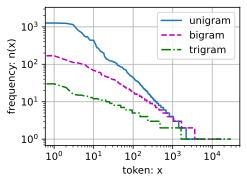

In [31]:
# Intuitively compare token frequencies among the three models
# Extract frequency information from the token_freqs of the bigram vocabulary and store it in the bigram_freqs list
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
# Extract frequency information from the token_freqs of the trigram vocabulary and store it in the trigram_freqs list
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
# Use the plot function from the d2l library to plot a comparison of token frequencies
# Pass the frequency information of unigrams, bigrams, and trigrams to the plot function
# Set the x-axis to token, the y-axis to frequency, and use logarithmic scale for both axes
# Include model names in the legend
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
        ylabel='frequency: n(x)', xscale='log', yscale='log',
        legend=['unigram', 'bigram', 'trigram'])

In [ ]:
# Randomly generate features and labels for a small batch of data for reading
# In random sampling, each sample is a randomly captured subsequence from the original long sequence

# Given a long sequence, it is continuously divided into many subsequences of length T
# A bit of randomness was added at the beginning to ensure that each cut is different
# When taking a random batch, they are taken out randomly
def seq_data_iter_random(corpus, batch_size, num_steps):
    """Generate a small batch of subsequences using random sampling"""

In [19]:
def seq_data_iter_random(seq, batch_size, num_steps):
  """Generate a random batch of data from a sequence."""
  # discard incomplete batches
  seq = seq[:len(seq) // num_steps * num_steps]
  # create a shuffled index
  indices = list(range(len(seq)))
  random.shuffle(indices)
  # create batches
  for i in range(0, len(seq), batch_size):
    # get a batch of indices
    batch_indices = indices[i:i + batch_size]
    # get a batch of data
    X = [seq[j] for j in batch_indices]
    # get the corresponding labels
    Y = [seq[j + 1] for j in batch_indices]
    # yield the batch of data and labels
    yield X, Y

In [20]:
def seq_data_iter(seq, batch_size=1, num_steps=30):
  """
  Generate randomly sampled small batch features and label data.
  Args:
    seq: the sequence to be split into batches
    batch_size: the size of each batch
    num_steps: the length of each sample
  """
  X = []
  Y = []
  for i in range(0, len(seq), num_steps):
    X.append(seq[i:i + num_steps])
    Y.append(seq[i + 1:i + num_steps + 1])
  return iter(zip(X, Y))

In [24]:
# Define my_seq

my_seq = list(range(0, 34))

In [25]:
for X, Y in seq_data_iter(my_seq, batch_size=1, num_steps=30):
  print('X: ', X, '\nY: ', Y)

X:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] 
Y:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
X:  [30, 31, 32, 33] 
Y:  [31, 32, 33]


In [26]:
# Ensure that subsequences in two adjacent small batches are also adjacent in the original sequence
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate small batches of subsequences using sequential partitioning"""
    # Randomly choose an offset as the starting position
    offset = random.randint(0, num_steps)
    # Calculate the total length of subsequences that can be generated
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    # Create a tensor for the feature sequence X
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    # Create a tensor for the label sequence Y
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    # Reshape Xs and Ys to become 2D tensors of shape (batch_size, -1)
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    # Calculate the number of batches that can be generated
    num_batches = Xs.shape[1] // num_steps
    # Iterate over each batch
    for i in range(0, num_steps * num_batches, num_steps):
        # Get the feature sequence X for the current batch
        X = Xs[:, i:i + num_steps]
        # Get the label sequence Y for the current batch
        Y = Ys[:, i:i + num_steps]
        # Use the yield statement to return X and Y as generator outputs
        yield X, Y

In [27]:
# Read the features X and labels Y for each small batch of sub-sequences
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    # The starting position of the second small batch follows the end position of the first small batch
    print('X: ', X, '\nY: ', Y) # The second mini-batch [9-13] follows the first mini-batch [3-7]

X:  tensor([[ 0,  1,  2,  3,  4],
        [16, 17, 18, 19, 20]]) 
Y:  tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]])
X:  tensor([[ 5,  6,  7,  8,  9],
        [21, 22, 23, 24, 25]]) 
Y:  tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]])
X:  tensor([[10, 11, 12, 13, 14],
        [26, 27, 28, 29, 30]]) 
Y:  tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]])
